# Bitcoin price forecast


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
import pandas as pd

df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727
1,2019-01-19,3652.377930,3758.533447,3652.377930,3728.568359,3728.568359,5955691380
2,2019-01-20,3725.446045,3743.387939,3583.019531,3601.013672,3601.013672,5582489560
3,2019-01-21,3600.372803,3608.840820,3558.537109,3576.032471,3576.032471,5004347059
4,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556


In [5]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2019-01-18,3657.839355
1,2019-01-19,3728.568359
2,2019-01-20,3601.013672
3,2019-01-21,3576.032471
4,2019-01-22,3604.577148


In [6]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

<ipython-input-7-6ba4ba08a90e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0   2019-01-18
1   2019-01-19
2   2019-01-20
3   2019-01-21
4   2019-01-22
Name: Date, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2019-01-18,3657.839355
2019-01-19,3728.568359
2019-01-20,3601.013672
2019-01-21,3576.032471
2019-01-22,3604.577148


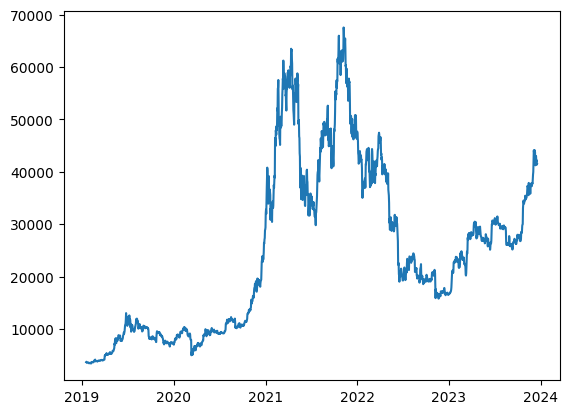

In [9]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [10]:
import numpy as np

def df_to_windowed_df(dataframe, n=3):
  target = df.loc[:,df.columns[-1]].to_numpy()
  dates = dataframe.index[n:].to_numpy()
  Y = target[n:]

  X = []
  i = 1
  while i != n + 1:
    X.append(target[n-i:-i])
    i += 1

  X.reverse()

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for j in range(0, n):
    ret_df[f'Target-{n-j}'] = X[j]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, n=5)
windowed_df.head()

,Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2019-01-23,3657.839355,3728.568359,3601.013672,3576.032471,3604.577148,3585.123047
1,2019-01-24,3728.568359,3601.013672,3576.032471,3604.577148,3585.123047,3600.865479
2,2019-01-25,3601.013672,3576.032471,3604.577148,3585.123047,3600.865479,3599.765869
3,2019-01-26,3576.032471,3604.577148,3585.123047,3600.865479,3599.765869,3602.460449
4,2019-01-27,3604.577148,3585.123047,3600.865479,3599.765869,3602.460449,3583.965820


In [11]:
dates_df = windowed_df['Date'].copy()
prices_df = windowed_df.drop(['Date'], axis=1).copy()
dates_df.shape, prices_df.shape

((1791,), (1791, 6))

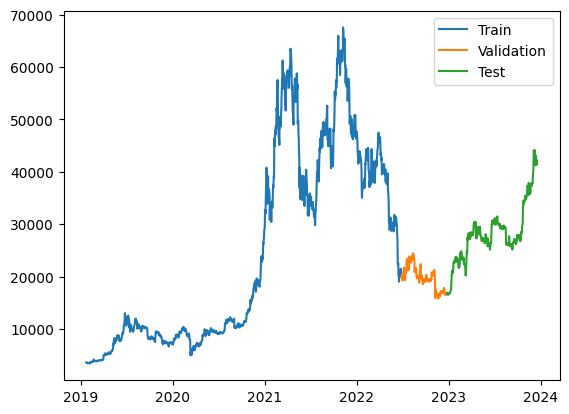

In [12]:
from sklearn.model_selection import train_test_split

train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

# divide into train, validation and test
dates_train_val, dates_test = train_test_split(dates_df, test_size=test_percentage, shuffle=False)
dates_train, dates_val = train_test_split(dates_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

prices_train_val, prices_test = train_test_split(prices_df, test_size=test_percentage, shuffle=False)
prices_train, prices_val = train_test_split(prices_train_val, test_size=val_percentage/(train_percentage+val_percentage), shuffle=False)

plt.plot(dates_train, prices_train['Target'])
plt.plot(dates_val, prices_val['Target'])
plt.plot(dates_test, prices_test['Target'])

plt.legend(['Train', 'Validation', 'Test'])

In [13]:
# fit scaler on train data
scaler = MinMaxScaler()
scaler.fit(prices_train)

# transform train, validation and test data
prices_train_scaled = scaler.transform(prices_train)
prices_val_scaled = scaler.transform(prices_val)
prices_test_scaled = scaler.transform(prices_test)

pd.DataFrame(prices_train_scaled).head()

,0,1,2,3,4,5
0,0.004026,0.005129,0.003141,0.002752,0.003196,0.002893
1,0.005129,0.003141,0.002752,0.003196,0.002893,0.003139
2,0.003141,0.002752,0.003196,0.002893,0.003139,0.003121
3,0.002752,0.003196,0.002893,0.003139,0.003121,0.003163
4,0.003196,0.002893,0.003139,0.003121,0.003163,0.002875


In [14]:
# divide prices in X and y
X_train = prices_train_scaled[:,:-1]
y_train = prices_train_scaled[:,-1]

X_val = prices_val_scaled[:,:-1]
y_val = prices_val_scaled[:,-1]

X_test = prices_test_scaled[:,:-1]
y_test = prices_test_scaled[:,-1]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1252, 5), (1252,), (180, 5), (180,), (359, 5), (359,))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
                    layers.Dropout(0.1),
                    layers.Dense(1)])

lr_schedule = InverseTimeDecay(0.0001,
                               decay_steps=1000,
                               decay_rate=0.97,
                               staircase=False)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
40/40 [==============================] - 3s 20ms/step - loss: 0.2591 - mean_absolute_error: 0.3162 - val_loss: 0.1202 - val_mean_absolute_error: 0.2139
Epoch 2/30
40/40 [==============================] - 0s 6ms/step - loss: 0.2118 - mean_absolute_error: 0.2694 - val_loss: 0.1059 - val_mean_absolute_error: 0.1824
Epoch 3/30
40/40 [==============================] - 0s 6ms/step - loss: 0.1797 - mean_absolute_error: 0.2302 - val_loss: 0.0884 - val_mean_absolute_error: 0.1323
Epoch 4/30
40/40 [==============================] - 0s 6ms/step - loss: 0.1427 - mean_absolute_error: 0.1880 - val_loss: 0.0747 - val_mean_absolute_error: 0.0734
Epoch 5/30
40/40 [==============================] - 0s 6ms/step - loss: 0.1096 - mean_absolute_error: 0.1526 - val_loss: 0.0682 - val_mean_absolute_error: 0.0206
Epoch 6/30
40/40 [==============================] - 0s 6ms/step - loss: 0.0882 - mean_absolute_error: 0.1209 - val_loss: 0.0675 - val_mean_absolute_error: 0.0301
Epoch 7/30
40/40 [=========

40/40 [==============================] - 1s 2ms/step


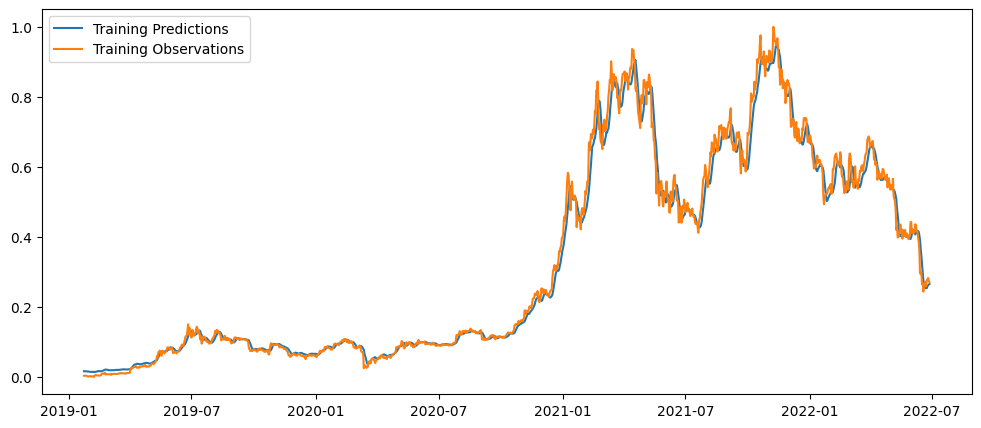

In [16]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 [==============================] - 0s 3ms/step


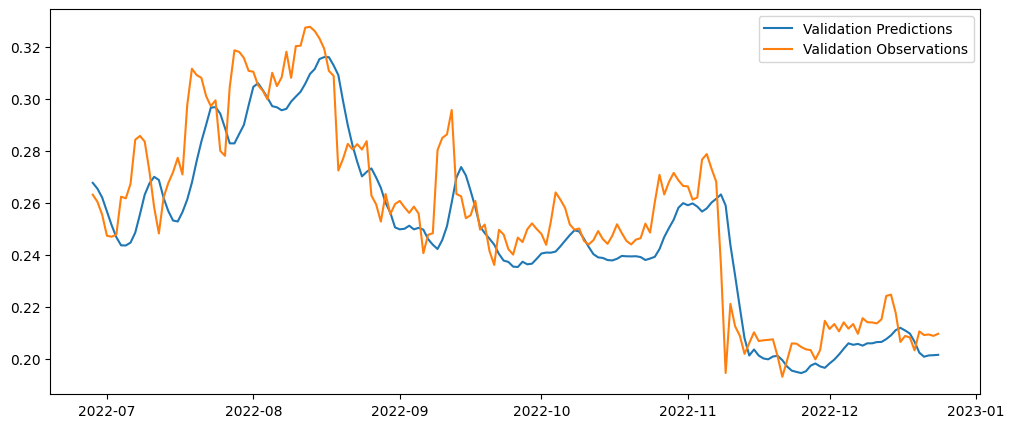

In [17]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

12/12 [==============================] - 0s 3ms/step


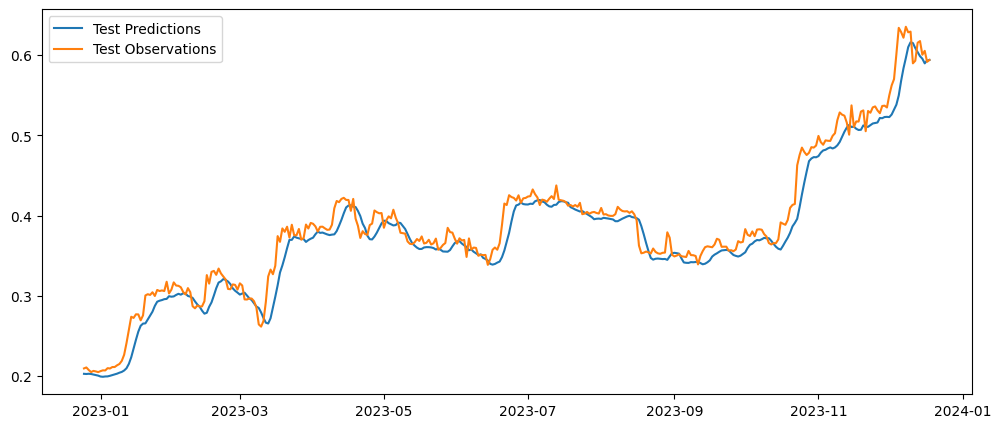

In [18]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])